In [73]:
# Importação de bibliotecas elencadas por ordem de acordo com as boas práticas da PEP 8
import re
from bs4 import BeautifulSoup
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests
from requests.exceptions import HTTPError


In [74]:
# Faz uma requisição HTTP para a URL especificada, captura e trata possíveis erros HTTP, além de armazenar o conteúdo da página web na variável conteudo para uso posterior
conteudo = None
URL = 'https://finance.yahoo.com/crypto/'

try:
    resposta = requests.get(URL)
    resposta.raise_for_status()
except HTTPError as exc:
    print(exc)
else:
    conteudo = resposta.text

In [75]:
# Analisa o conteúdo da página Web através da biblioteca BeautifulSoup que foi armazenado na variável conteúdo, o 'html.parser' é quem realiza a análise
pagina = BeautifulSoup(conteudo, 'html.parser')

#Procura por uma tabela na página, se ela for encontrada, há o prosseguimento
tabela = pagina.find('table')
if tabela is not None:
    cabecalho = [th.get_text() for th in tabela.find_all('th')]  # Lista chamada cabecalho, na qual você extrai o texto dos elementos <th> (cabeçalho da tabela) encontrados na tabela
    linhas = tabela.find_all('tr') # Procurando por todas as linhas (<tr>)
    dados = [] # Cria uma lista vazia que será usada para armazenar as informações de cada linha da tabela.

    for linha in linhas[1:]: # Faz a iteração das linahs começando pela segunda
        valores = [re.sub(r'\s+', ' ', td.get_text().strip()) for td in linha.find_all('td')] #S ubstituição para remover espaços extras usando a expressão regular re.sub
        dados.append(valores)

    yahoo_crypto_df = pd.DataFrame(dados, columns=cabecalho) # Cria o DataFrame yahoo_crypto_df que é construído usando as listas dados (linhas) e cabecalho (colunas).
    yahoo_crypto_df.replace(to_replace=[r'\$', r'\%'], value='', regex=True, inplace=True) # Faz a remoção dos símbolos de dólar ($) e porcentagem (%) das células.

    # Comentando a linha de salvamento do arquivo CSV
    arquivo_csv = Path.cwd() / 'yahoo_crypto-limpo.csv'
    yahoo_crypto_df.to_csv(arquivo_csv, mode='w', encoding='utf8', sep=';', index=False)

    # Imprimir o DataFrame diretamente no console
    print(yahoo_crypto_df)

    print("Dados impressos com sucesso!")
else:
    print("Tabela não encontrada na página HTML.")

          Symbol                 Name Price (Intraday)       Change % Change  \
0        BTC-USD          Bitcoin USD        29,138.33       +88.56    +0.30   
1        ETH-USD         Ethereum USD         1,824.80        -1.88    -0.10   
2       USDT-USD      Tether USDt USD         0.998792    +0.000361    +0.04   
3        BNB-USD              BNB USD           241.44        -1.36    -0.56   
4        XRP-USD              XRP USD         0.620141    -0.004468    -0.72   
5       USDC-USD         USD Coin USD         0.999980    +0.000163    +0.02   
6      STETH-USD  Lido Staked ETH USD         1,821.42        -0.97    -0.05   
7       DOGE-USD         Dogecoin USD         0.073265    -0.001176    -1.58   
8        ADA-USD          Cardano USD         0.289595    -0.002643    -0.90   
9        SOL-USD           Solana USD            22.99        -0.24    -1.03   
10      WTRX-USD     Wrapped TRON USD         0.076522    -0.000384    -0.50   
11       TRX-USD             TRON USD   

In [76]:
#Tratando os dados das colunas
yahoo_crypto_df.rename(columns={'Symbol': 'symbol'}, inplace=True)
yahoo_crypto_df.rename(columns={'Name': 'name'}, inplace=True)
yahoo_crypto_df.rename(columns={'Price (Intraday)': 'price_day'}, inplace=True)
yahoo_crypto_df.rename(columns={'Change': 'change'}, inplace=True)
yahoo_crypto_df.rename(columns={'% Change': 'change_percent'}, inplace=True)
yahoo_crypto_df.rename(columns={'Market Cap': 'market_value'}, inplace=True)
yahoo_crypto_df.rename(columns={'Volume in Currency (24Hr)': 'volume_currency_24h'}, inplace=True)
yahoo_crypto_df.rename(columns={'Total Volume All Currencies (24Hr)': 'total_volume_currency_24h'}, inplace=True)
yahoo_crypto_df.rename(columns={'Circulating Supply': 'circulating_supply'}, inplace=True)

yahoo_crypto_df.drop(columns = ['Volume in Currency (Since 0:00 UTC)'], inplace=True)
yahoo_crypto_df.drop(columns = ['52 Week Range'], inplace=True)
yahoo_crypto_df.drop(columns = ['Day Chart'], inplace=True)

yahoo_crypto_df['price_day'] = yahoo_crypto_df['price_day'].str.replace(',', '')  # Remover as vírgulas
yahoo_crypto_df['price_day'] = yahoo_crypto_df['price_day'].astype(float) # Converção valores para float
yahoo_crypto_df['change_percent'] = pd.to_numeric(yahoo_crypto_df['change_percent'], errors='coerce')  # Converção para valores numéricos

# Filtrando por criptomoedas que apresentem mudanças percentuais positivas no dia
filtered_df = yahoo_crypto_df.query('change_percent > 0.00')

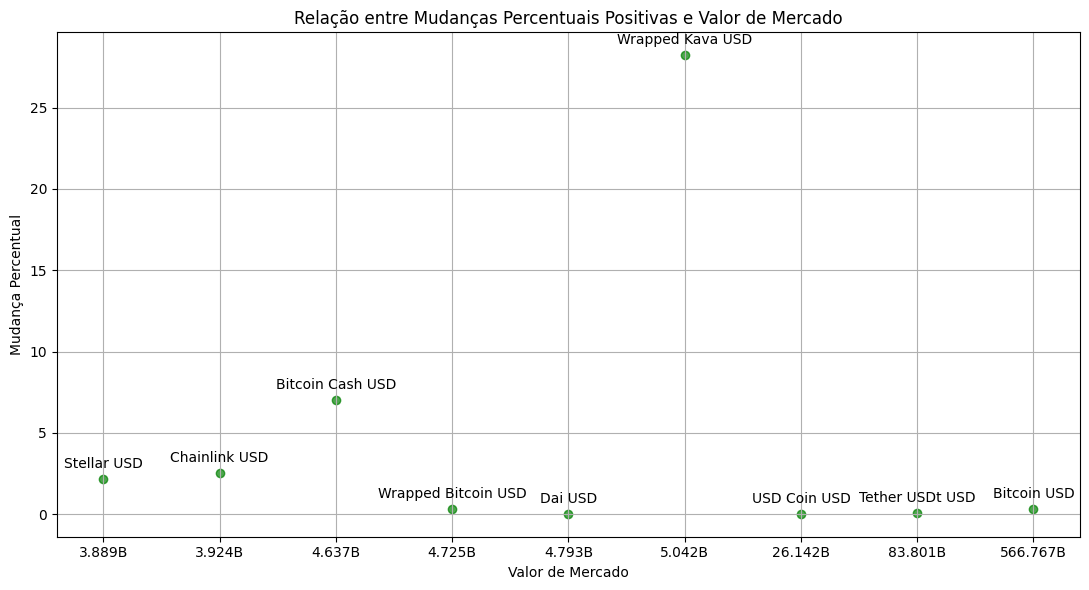

In [77]:
# Adicionar rótulos aos eixos
plt.figure(figsize=(11, 6))
plt.scatter(filtered_df['market_value'], filtered_df['change_percent'], color='green', alpha=0.7)
plt.xlabel('Valor de Mercado')
plt.ylabel('Mudança Percentual')
plt.title('Relação entre Mudanças Percentuais Positivas e Valor de Mercado')
plt.grid(True)
plt.tight_layout()

# O laço for permitirá  iterar sobre as linhas do DataFrame, retornando o índice da linha (i) e os dados da linha (row) em cada iteração.
for i, row in filtered_df.iterrows():
    plt.annotate(row['name'], (row['market_value'], row['change_percent']),
                 textcoords="offset points", xytext=(0,8), ha='center')

# Inverter o eixo x para exibir em ordem crescente, pois o Matplotlib escolhe automaticamente a escala e os limites dos eixos e nesse caso o gráfico viria com o eixo x de forma decrescente.
plt.gca().invert_xaxis()

plt.show()